In [1]:
import os
from cv2 import imread
import matplotlib.pyplot as plt

import keras
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50, VGG19

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2, 
    validation_split=0.1)    

training_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path,
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="training",
                                                 color_mode='rgb',
                                                 class_mode='binary')

testing_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path,
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="validation",
                                                 color_mode='rgb',
                                                 class_mode='binary')

Found 229 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


<h4>Tumour MRI Image</h4>

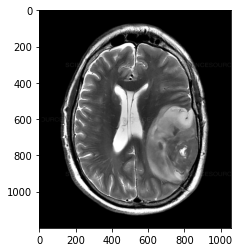

In [3]:
yes_path = path+"/yes/"+os.listdir(path+"/yes/")[4]
tumour = imread(yes_path)
plt.imshow(tumour)

<h4>Normal MRI Image</h4>

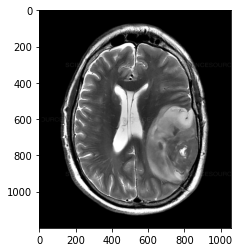

In [4]:
no_path = path+"/no/"+os.listdir(path+"/no/")[4]
tumour = imread(yes_path)
plt.imshow(tumour)

In [5]:
testing_set.class_indices

{'no': 0, 'yes': 1}

<h3>VGG 19</h3>

In [6]:
model = VGG19(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )


2022-05-24 16:24:26.361848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:24:26.372468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:24:26.373386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:24:26.374719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [7]:
for layers in model.layers:
    layers.trainable = False

In [8]:
x = Flatten()(model.output)
x = Dropout(0.4)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
hist = model.fit_generator(training_set,validation_data = training_set, epochs = 60)

2022-05-24 16:24:28.733001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-05-24 16:24:29.963041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15/15 [==============================] - 7s 235ms/step - loss: 0.7767 - accuracy: 0.6157 - val_loss: 0.5061 - val_accuracy: 0.7686
Epoch 2/60
15/15 [==============================] - 3s 170ms/step - loss: 0.4979 - accuracy: 0.7686 - val_loss: 0.3673 - val_accuracy: 0.8384
Epoch 3/60
15/15 [==============================] - 3s 184ms/step - loss: 0.3829 - accuracy: 0.8297 - val_loss: 0.3141 - val_accuracy: 0.8559
Epoch 4/60
15/15 [==============================] - 3s 181ms/step - loss: 0.3740 - accuracy: 0.8253 - val_loss: 0.4299 - val_accuracy: 0.8079
Epoch 5/60
15/15 [==============================] - 3s 172ms/step - loss: 0.3437 - accuracy: 0.8428 - val_loss: 0.3379 - val_accuracy: 0.8515
Epoch 6/60
15/15 [==============================] - 2s 169ms/step - loss: 0.3228 - accuracy: 0.8777 - val_loss: 0.3570 - val_accuracy: 0.8297
Epoch 7/60
15/15 [==============================] - 3s 192ms/step - loss: 0.2709 - accuracy: 0.8821 - val_loss: 0.2168 - val_accuracy: 0.9345
Epoch 8/60
15/15 

In [10]:
hist = hist.history

Text(0, 0.5, 'accuracy')

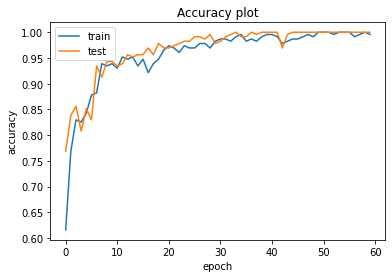

In [11]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

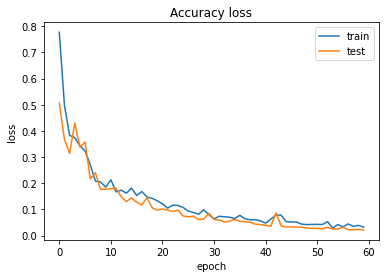

In [12]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing

<h3>ResNet 50</h3>

In [13]:
model = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )


In [14]:
for layers in model.layers:
    layers.trainable = False

In [15]:
x = Flatten()(model.output)
x = Dropout(0.4)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [16]:
hist = model.fit_generator(training_set,validation_data = training_set, epochs = 60)

Epoch 1/60
15/15 [==============================] - 7s 272ms/step - loss: 1.7687 - accuracy: 0.5808 - val_loss: 1.0359 - val_accuracy: 0.6900
Epoch 2/60
15/15 [==============================] - 3s 172ms/step - loss: 1.1322 - accuracy: 0.6638 - val_loss: 1.1541 - val_accuracy: 0.5939
Epoch 3/60
15/15 [==============================] - 3s 177ms/step - loss: 0.6929 - accuracy: 0.7074 - val_loss: 1.6615 - val_accuracy: 0.4498
Epoch 4/60
15/15 [==============================] - 3s 178ms/step - loss: 1.1660 - accuracy: 0.6594 - val_loss: 0.6962 - val_accuracy: 0.6987
Epoch 5/60
15/15 [==============================] - 3s 194ms/step - loss: 0.7795 - accuracy: 0.7249 - val_loss: 0.5236 - val_accuracy: 0.8122
Epoch 6/60
15/15 [==============================] - 3s 172ms/step - loss: 0.6484 - accuracy: 0.7598 - val_loss: 0.4031 - val_accuracy: 0.8297
Epoch 7/60
15/15 [==============================] - 3s 178ms/step - loss: 0.4062 - accuracy: 0.8122 - val_loss: 0.3769 - val_accuracy: 0.8384
Epoch 

In [17]:
hist = hist.history

Text(0, 0.5, 'accuracy')

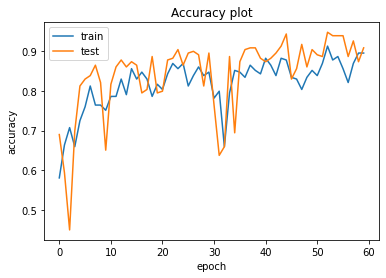

In [18]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

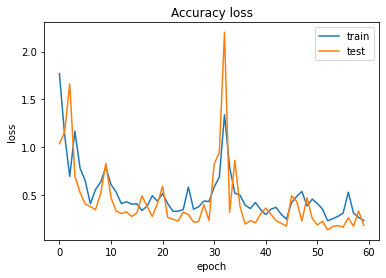

In [19]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing